# Data Analysis PXD040621

Plan
- read data and log2 transform intensity values
- aggregate peptide intensities to protein intensities
- format data from long to wide format
- remove contaminant proteins
- check for missing values
- Clustermap of sample and proteins
- differential analysis (Volcano Plots)
- Enrichment Analysis
- check for maltose update pathway (Fig. 3 in paper)

In [1]:
from pathlib import Path

import acore.differential_regulation
import acore.enrichment_analysis
import acore.normalization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import vuecore
from acore.io.uniprot import fetch_annotations, process_annotations
from vuecore.viz import get_enrichment_plots

## Read in the data
- `file_in`: input file with the quantified peptide data in MSstats format as provided by quantms

The file can be downloaded from [Google Drive](https://drive.google.com/drive/folders/1Nm5Ha-tCvjU-B323BLhna1GwHdNpK_lU?usp=drive_link)

In [2]:
file_in = "data/PXD040621/processed/PXD040621.sdrf_openms_design_msstats_in.csv"
df = pd.read_csv(file_in, sep=",", header=0)  # .set_index([])
df.head()

ProteinName             PeptideSequence  PrecursorCharge  \
0  sp|P00959|SYM_ECOLI  AAAAPVTGPLADDPIQETITFDDFAK                2   
1  sp|P00959|SYM_ECOLI  AAAAPVTGPLADDPIQETITFDDFAK                2   
2  sp|P00959|SYM_ECOLI  AAAAPVTGPLADDPIQETITFDDFAK                2   
3  sp|P00959|SYM_ECOLI  AAAAPVTGPLADDPIQETITFDDFAK                2   
4  sp|P00959|SYM_ECOLI  AAAAPVTGPLADDPIQETITFDDFAK                2   

   FragmentIon  ProductCharge IsotopeLabelType     Condition  BioReplicate  \
0          NaN              0                L       Control             1   
1          NaN              0                L       Control             2   
2          NaN              0                L       Control             3   
3          NaN              0                L       Control             4   
4          NaN              0                L  Sulforaphane             5   

   Run       Intensity                                          Reference  
0    1 201,065,600.000  20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1....  
1    2  74,844,780.000  20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2....  
2    3  67,591,410.000  20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3....  
3    4  76,388,800.000  20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4....  
4    5 116,247,100.000  20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML

define the output folder for our VueGen report which we will create later

In [3]:
out_dir = "data/PXD040621/report/"
out_dir = Path(out_dir)
out_dir.mkdir(parents=True, exist_ok=True)

We have the following columns in the data:

```python
cols = [
    "ProteinName",
    "PeptideSequence",
    "PrecursorCharge",
    "FragmentIon",
    "ProductCharge",
    "IsotopeLabelType",
    "Condition",
    "BioReplicate",
    "Run",
    "Intensity",
    "Reference",
]

## Log2 transform the intensity values
- log2 transformations are common for lognormal distributed data

In [4]:
df["Intensity"] = np.log2(df["Intensity"].astype(float))

## Aggregate the peptide intensities to protein intensities
- we use the median of the peptide intensities for each protein

There are more sophisticated ways to do this, e.g. using MaxLFQ, iBAQ, FlashLFQ, DirectLFQ, etc.

In [5]:
proteins = (
    df.groupby(["ProteinName", "Reference"])["Intensity"].median().unstack(level=0)
)
proteins

ProteinName                                         CON_A2AB72  CON_O76013  \
Reference                                                                    
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML         NaN         NaN   
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML      23.997      25.647   
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML         NaN         NaN   
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML         NaN         NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML          NaN         NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML          NaN         NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML          NaN         NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML          NaN         NaN   

ProteinName                                         CON_P00761  CON_P01966  \
Reference                                                                    
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML      31.056         NaN   
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML      29.515      25.711   
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML      33.670         NaN   
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML      34.139         NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML       34.541         NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML       33.175         NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML       31.799         NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML       33.857         NaN   

ProteinName                                         CON_P02070  CON_P02533  \
Reference                                                                    
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML      26.929      28.336   
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML         NaN      25.595   
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML         NaN      26.992   
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML         NaN      27.205   
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML          NaN         NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML       26.571      26.495   
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML          NaN      26.249   
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML          NaN      27.208   

ProteinName                                         CON_P02538  CON_P02662  \
Reference                                                                    
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML      25.828         NaN   
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML      26.210         NaN   
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML      25.441      28.129   
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML      26.093         NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML       24.442         NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML       25.070         NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML       28.169      23.067   
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML       24.690         NaN   

ProteinName                                         CON_P02663  CON_P02666  \
Reference                                                                    
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML      26.804         NaN   
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML      27.593         NaN   
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML      28.895      27.111   
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML      27.764         NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML       25.938         NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML          NaN         NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML       26.466         NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML          NaN         NaN   

ProteinName                                         ...  sp|Q47319|TAPT_ECOLI  \
Reference     

## Remove contaminant proteins
Remove the contaminant proteins which were added to the fasta file used in the data processing.
Contaminant proteins are e.g. creation which gets into the sample from the human skin or hair
when the sample is prepared.

These are filtered out as they are most of the time not relevant, but a contamination.

In [6]:
decoy_proteins = proteins.filter(like="CON_", axis=1)
proteins = proteins.drop(decoy_proteins.columns, axis=1)
proteins

ProteinName                                         sp|A5A613|YCIY_ECOLI  \
Reference                                                                  
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML                27.180   
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML                   NaN   
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML                   NaN   
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML                   NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML                    NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML                    NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML                    NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML                    NaN   

ProteinName                                         sp|P00350|6PGD_ECOLI  \
Reference                                                                  
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML                28.193   
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML                27.926   
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML                27.329   
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML                27.152   
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML                 27.442   
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML                 27.032   
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML                 27.815   
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML                 27.404   

ProteinName                                         sp|P00363|FRDA_ECOLI  \
Reference                                                                  
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML                30.247   
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML                29.995   
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML                29.983   
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML                29.907   
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML                 30.183   
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML                 30.086   
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML                 29.904   
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML                 29.575   

ProteinName                                         sp|P00370|DHE4_ECOLI  \
Reference                                                                  
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML                27.459   
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML                26.873   
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML                26.499   
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML                26.435   
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML                 27.400   
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML                 27.283   
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML                 27.114   
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML                 27.224   

ProteinName                                         sp|P00393|NDH_ECOLI  \
Reference                                                                 
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML               26.864   
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML               25.613   
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML               26.012   
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML               25.799   
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML                26.671   
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML                26.886   
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML                26.750   
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML                26.343   

ProteinName                                         sp|P00448|SODM_ECOLI  \
Reference                                                                  
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML   

Create a label for each sample based on the metadata.
- we will use a string in the sample name, but you can see how the metadata is organized

In [7]:
meta = df[["Condition", "BioReplicate", "Run", "Reference"]].drop_duplicates()
meta

Condition  BioReplicate  Run  \
0       Control             1    1   
1       Control             2    2   
2       Control             3    3   
3       Control             4    4   
4  Sulforaphane             5    5   
5  Sulforaphane             6    6   
6  Sulforaphane             7    7   
7  Sulforaphane             8    8   

                                           Reference  
0  20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1....  
1  20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2....  
2  20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3....  
3  20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4....  
4  20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML  
5  20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML  
6  20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML  
7  20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML

In [8]:
label_encoding = {0: "control", 1: "10 µm sulforaphane"}
label_suf = pd.Series(
    proteins.index.str.contains("_Suf_").astype(int),
    index=proteins.index,
    name="label_suf",
    dtype=np.int8,
).map(label_encoding)
label_suf

Reference
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML               control
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML               control
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML               control
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML               control
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML     10 µm sulforaphane
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML     10 µm sulforaphane
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML     10 µm sulforaphane
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML     10 µm sulforaphane
Name: label_suf, dtype: object

## Plot the data completeness for each protein.

In [9]:
view_name = "Protein"
out_dir_subsection = out_dir / "1_data" / "completeness"
out_dir_subsection.mkdir(parents=True, exist_ok=True)

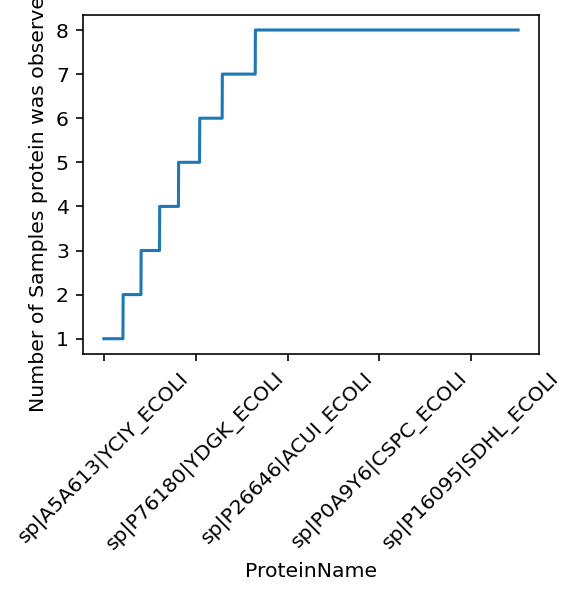

In [10]:
view_name = "Protein"
ax = (
    proteins.notna()
    .sum()
    .sort_values()
    .plot(
        rot=45,
        ylabel=f"Number of Samples {view_name.lower()} was observed in",
    )
)
ax.get_figure().savefig(
    out_dir_subsection / f"data_completeness_step_plot.png",
    bbox_inches="tight",
    dpi=300,
)

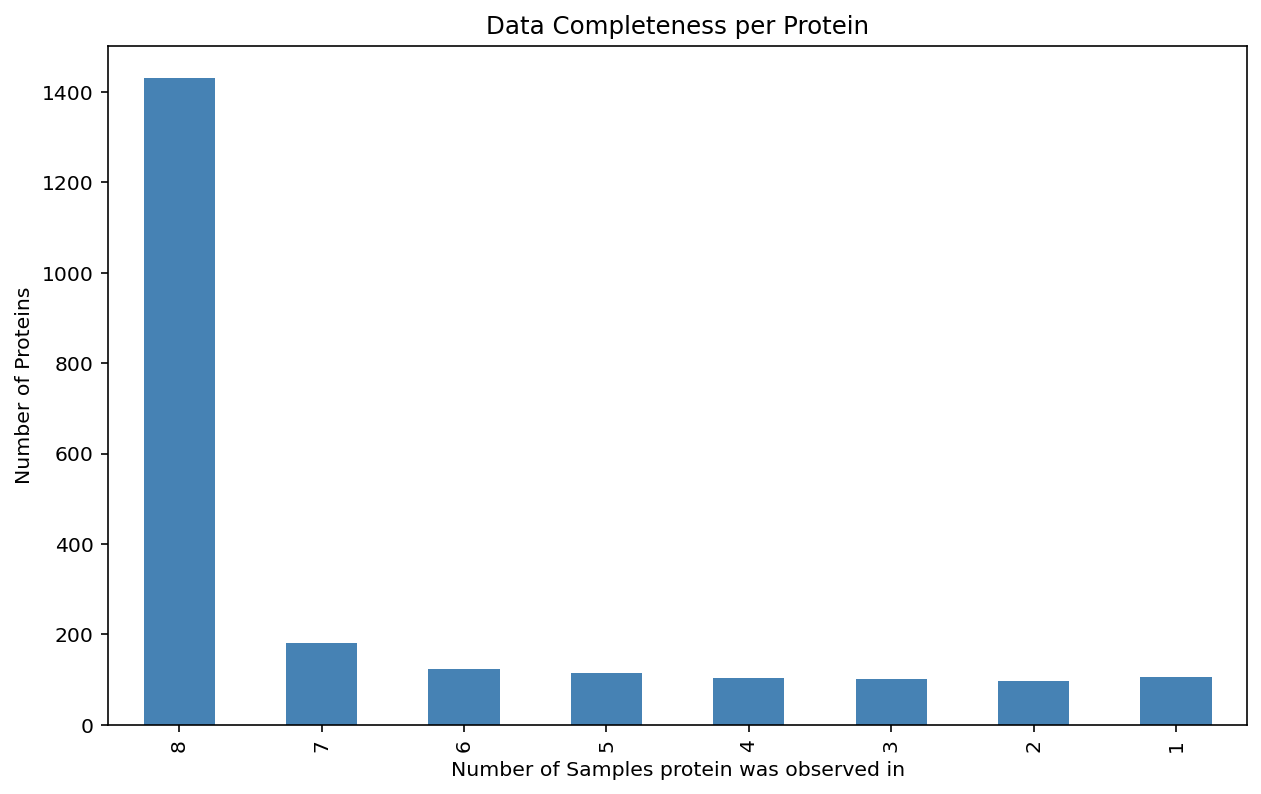

In [11]:
view_name = "Protein"
ax = (
    proteins.notna()
    .sum()
    .value_counts()
    .sort_index(ascending=False)
    .plot(
        kind="bar",
        title=f"Data Completeness per {view_name}",
        xlabel=f"Number of Samples {view_name.lower()} was observed in",
        ylabel=f"Number of {view_name}s",
        color="steelblue",
        figsize=(10, 6),
    )
)
ax.get_figure().savefig(
    out_dir_subsection / f"data_completeness_bar_plot.png",
    bbox_inches="tight",
    dpi=300,
)

In [12]:
# Explode column names to examine split by '|'
proteins_meta = (
    proteins.columns.str.split("|", expand=True)
    .to_frame()
    .dropna(how="any", axis=1)
    .reset_index(drop=True)
)
proteins_meta.columns = ["Source", "ProteinName", "GeneName"]
proteins_meta["GeneName"] = proteins_meta["GeneName"].str.split("_").str[0]
proteins_meta.index = proteins.columns
proteins_meta.index.name = "identifier"
proteins_meta

Source ProteinName GeneName
identifier                                        
sp|A5A613|YCIY_ECOLI       sp      A5A613     YCIY
sp|P00350|6PGD_ECOLI       sp      P00350     6PGD
sp|P00363|FRDA_ECOLI       sp      P00363     FRDA
sp|P00370|DHE4_ECOLI       sp      P00370     DHE4
sp|P00393|NDH_ECOLI        sp      P00393      NDH
...                       ...         ...      ...
sp|Q57261|TRUD_ECOLI       sp      Q57261     TRUD
sp|Q59385-2|COPA_ECOLI     sp    Q59385-2     COPA
sp|Q59385|COPA_ECOLI       sp      Q59385     COPA
sp|Q7DFV3|YMGG_ECOLI       sp      Q7DFV3     YMGG
sp|Q93K97|ADPP_ECOLI       sp      Q93K97     ADPP

[2256 rows x 3 columns]

For later convenience let's replace the identifier with the UNIPROT ID

In [13]:
proteins.columns = proteins_meta["ProteinName"]
proteins

ProteinName                                         A5A613  P00350  P00363  \
Reference                                                                    
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML  27.180  28.193  30.247   
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML     NaN  27.926  29.995   
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML     NaN  27.329  29.983   
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML     NaN  27.152  29.907   
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML      NaN  27.442  30.183   
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML      NaN  27.032  30.086   
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML      NaN  27.815  29.904   
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML      NaN  27.404  29.575   

ProteinName                                         P00370  P00393  P00448  \
Reference                                                                    
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML  27.459  26.864  28.493   
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML  26.873  25.613  24.901   
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML  26.499  26.012  25.054   
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML  26.435  25.799  24.825   
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML   27.400  26.671  25.564   
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML   27.283  26.886  25.378   
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML   27.114  26.750  25.398   
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML   27.224  26.343  25.360   

ProteinName                                         P00452  P00490  P00509  \
Reference                                                                    
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML     NaN  27.863  29.979   
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML     NaN  26.439  29.048   
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML  27.172  26.382  28.777   
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML     NaN  26.791  29.485   
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML      NaN  27.657  29.295   
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML   27.364  27.468  29.079   
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML   26.062  27.541  29.234   
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML   24.924  27.705  29.334   

ProteinName                                         P00547  ...  Q47319  \
Reference                                                   ...           
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML  26.065  ...     NaN   
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML     NaN  ...     NaN   
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML     NaN  ...     NaN   
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML  25.524  ...     NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML      NaN  ...     NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML      NaN  ...     NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML   26.265  ...  25.463   
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML   26.427  ...     NaN   

ProteinName                                         Q47536  Q47622  Q47679  \
Reference                                                                    
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML     NaN  25.638     NaN   
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML     NaN     NaN     NaN   
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML     NaN  24.576     NaN   
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML     NaN  25.945  23.902   
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML      NaN  25.836     NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML      NaN     NaN  24.253   
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML      NaN     NaN     NaN   
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML   24.468  24.757     NaN   

ProteinName                                         Q47710  Q57261  Q59385-2  \
Reference                                    

And let's save a table with the data for inspection

In [14]:
proteins_meta.to_csv(out_dir_subsection / "proteins_identifiers.csv")
proteins.to_csv(out_dir_subsection / "proteins.csv")

## Hierarchical Clustering of data
- using completely observed data only
Find correlations in data

In [15]:
out_dir_subsection = out_dir / "1_data" / "clustermap"

In [16]:
_group_labels = label_encoding.values()
lut = dict(zip(_group_labels, [f"C{i}" for i in range(len(_group_labels))]))
row_colors = label_suf.map(lut).rename("group color")
row_colors

Reference
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML    C0
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML    C0
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML    C0
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML    C0
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML     C1
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML     C1
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML     C1
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML     C1
Name: group color, dtype: object

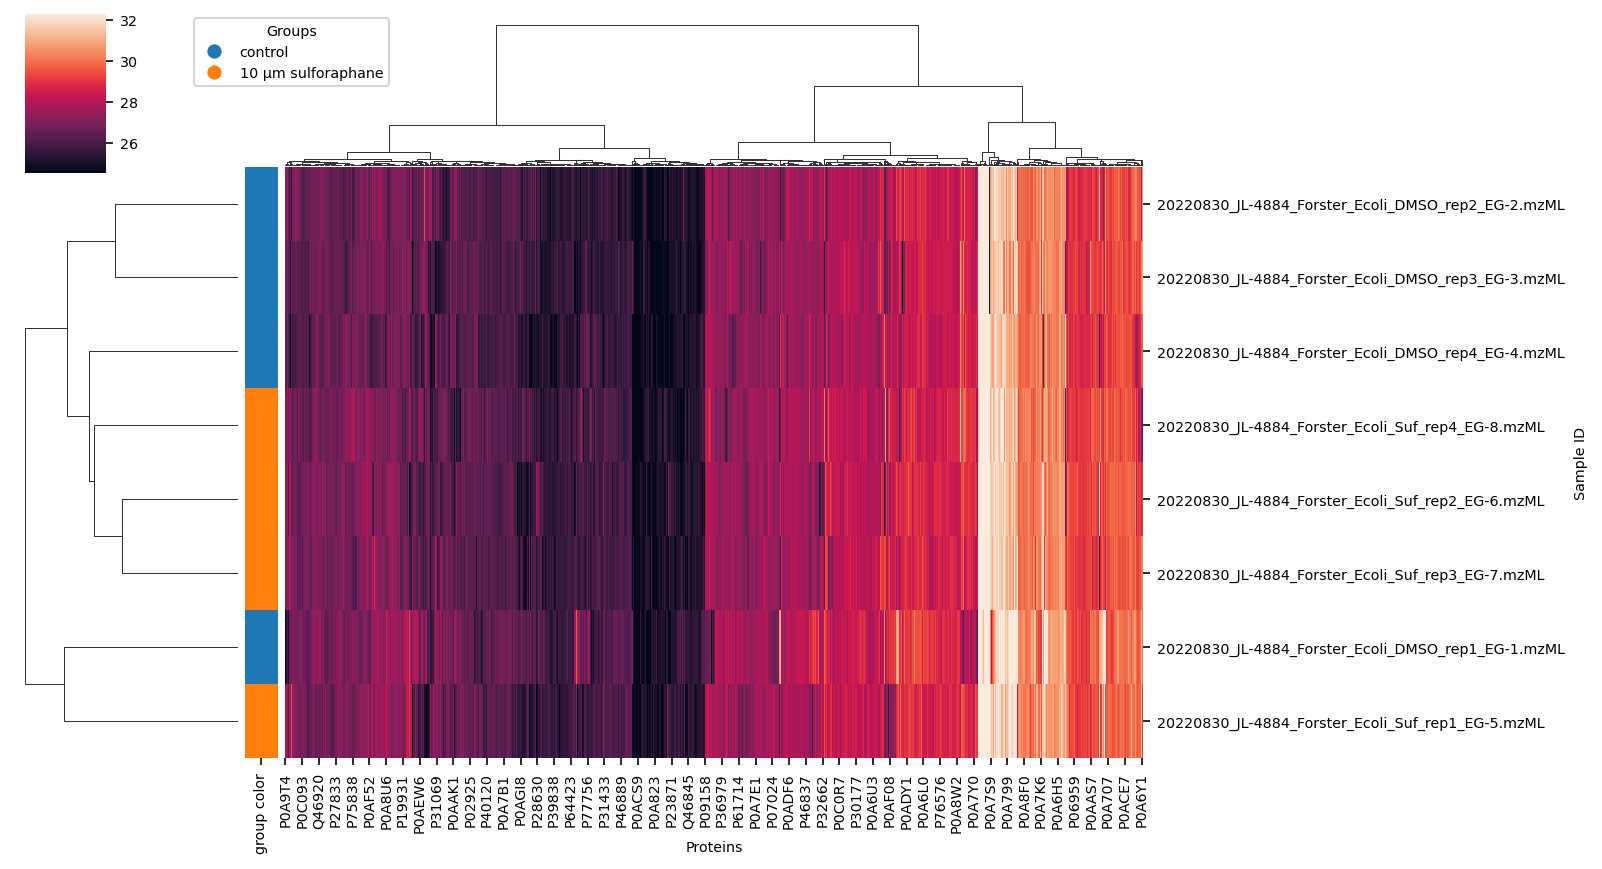

In [17]:
vuecore.set_font_sizes(7)
cg = sns.clustermap(
    proteins.dropna(how="any", axis=1),
    method="ward",
    row_colors=row_colors,
    figsize=(11, 6),
    robust=True,
    xticklabels=True,
    yticklabels=True,
)
fig = cg.figure
cg.ax_heatmap.set_xlabel("Proteins")
cg.ax_heatmap.set_ylabel("Sample ID")
vuecore.select_xticks(cg.ax_heatmap)
handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=lut[name], markersize=8)
    for name in lut
]
cg.ax_cbar.legend(
    handles, _group_labels, title="Groups", loc="lower left", bbox_to_anchor=(2, 0.5)
)
fname = out_dir_subsection / "clustermap_ward.png"
# vuecore.savefig(fig, fname, pdf=True, dpi=600, tight_layout=False)
fig.savefig(
    out_dir_subsection / "clustermap_ward.png",
    bbox_inches="tight",
    dpi=300,
)

### Hierarchical Clustering of normalized data
- using completely observed data only
Checkout the [recipe on normalization methods](https://analytics-core.readthedocs.io/latest/api_examples/normalization_analysis.html).

In [18]:
normalization_method = "median"
X = acore.normalization.normalize_data(
    proteins.dropna(how="any", axis=1), normalization_method
)
X

ProteinName                                         P00350  P00363  P00370  \
Reference                                                                    
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML  27.910  29.964  27.176   
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML  28.064  30.132  27.011   
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML  27.537  30.192  26.708   
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML  27.349  30.104  26.632   
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML   27.270  30.011  27.228   
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML   27.012  30.066  27.263   
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML   27.835  29.924  27.134   
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML   27.370  29.541  27.190   

ProteinName                                         P00393  P00448  P00490  \
Reference                                                                    
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML  26.581  28.210  27.580   
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML  25.751  25.039  26.576   
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML  26.221  25.262  26.590   
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML  25.996  25.022  26.987   
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML   26.500  25.392  27.485   
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML   26.866  25.358  27.449   
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML   26.770  25.418  27.561   
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML   26.309  25.326  27.671   

ProteinName                                         P00509  P00550  P00561  \
Reference                                                                    
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML  29.696  26.482  26.837   
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML  29.185  26.388  26.516   
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML  28.985  27.225  26.727   
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML  29.682  26.911  26.818   
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML   29.124  26.646  26.774   
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML   29.059  27.316  27.143   
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML   29.254  27.029  26.826   
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML   29.300  27.297  26.582   

ProteinName                                         P00562  ...  Q46868  \
Reference                                                   ...           
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML  27.161  ...  29.150   
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML  26.932  ...  29.868   
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML  27.198  ...  29.728   
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML  26.705  ...  28.683   
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML   27.038  ...  29.614   
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML   26.767  ...  28.963   
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML   27.286  ...  29.048   
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML   26.946  ...  27.908   

ProteinName                                         Q46893  Q46920  Q46948  \
Reference                                                                    
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML  27.876  26.857  26.930   
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML  27.814  26.840  27.330   
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML  28.860  26.890  27.238   
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML  28.323  27.338  27.603   
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML   28.416  26.877  27.715   
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML   28.562  27.086  27.488   
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML   28.397  27.260  27.271   
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML   28.767  27.113  27.643   

ProteinName                                         Q47147  Q47710  Q57261  \
Reference                                      

In [19]:
X.median(axis="columns")

Reference
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1.mzML   27.297
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2.mzML   27.297
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3.mzML   27.297
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4.mzML   27.297
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5.mzML    27.297
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6.mzML    27.297
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7.mzML    27.297
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8.mzML    27.297
dtype: float64

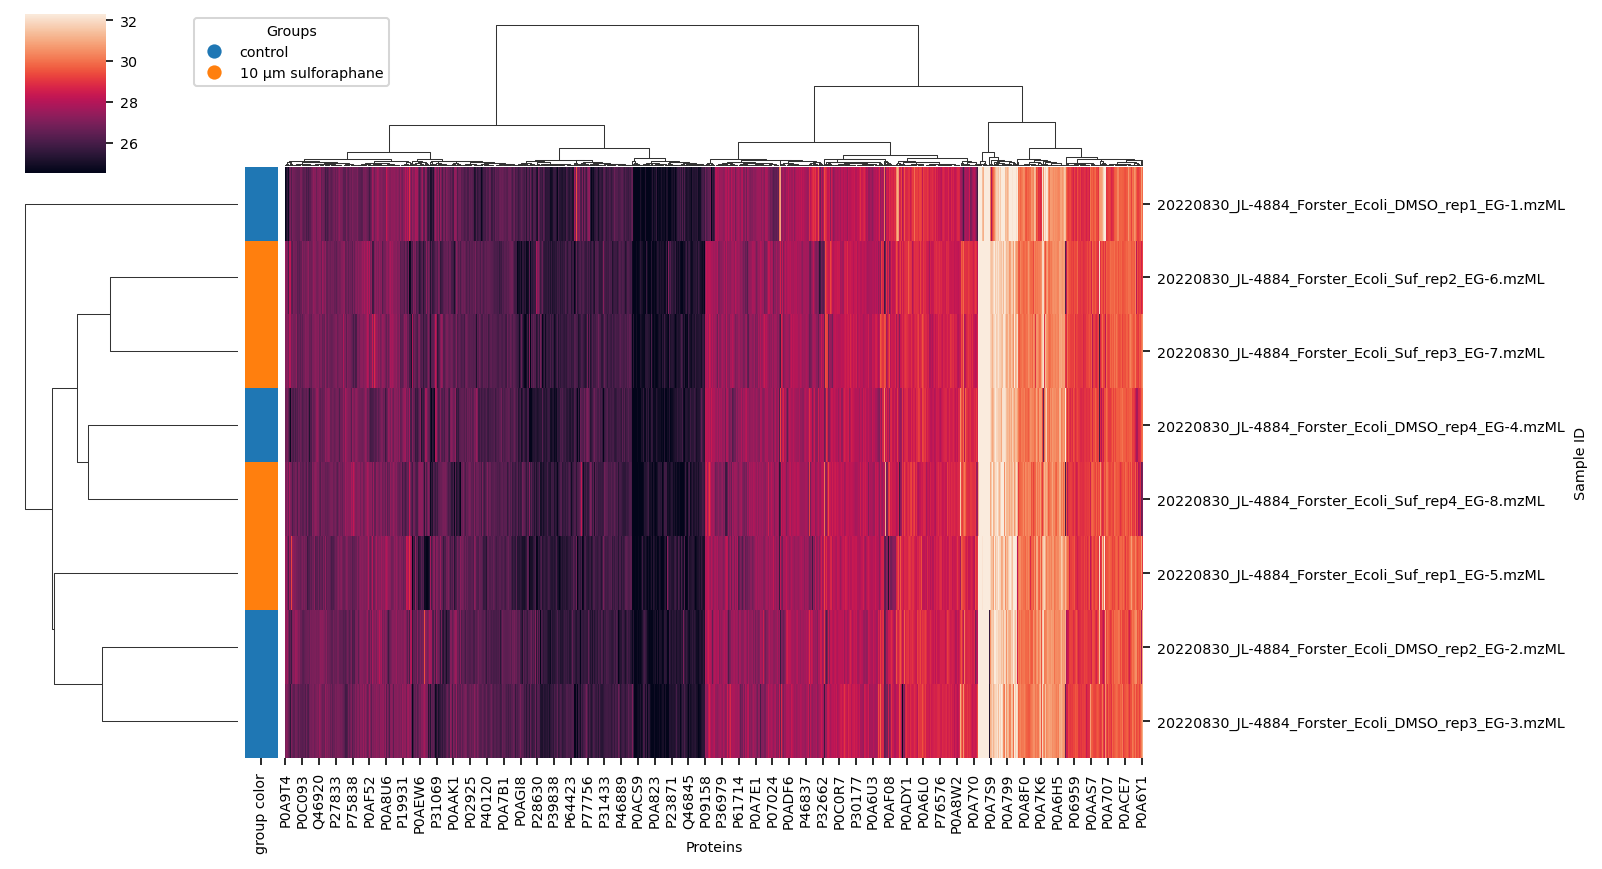

In [20]:
vuecore.set_font_sizes(7)
cg = sns.clustermap(
    X,
    method="ward",
    row_colors=row_colors,
    figsize=(11, 6),
    robust=True,
    xticklabels=True,
    yticklabels=True,
)
fig = cg.figure
cg.ax_heatmap.set_xlabel("Proteins")
cg.ax_heatmap.set_ylabel("Sample ID")
vuecore.select_xticks(cg.ax_heatmap)
handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=lut[name], markersize=8)
    for name in lut
]
cg.ax_cbar.legend(
    handles, _group_labels, title="Groups", loc="lower left", bbox_to_anchor=(2, 0.5)
)
fname = out_dir_subsection / "clustermap_ward.png"
# vuecore.savefig(fig, fname, pdf=True, dpi=600, tight_layout=False)
fig.savefig(
    out_dir_subsection / f"clustermap_ward_{normalization_method}.png",
    bbox_inches="tight",
    dpi=300,
)

## Differential Regulation

In [21]:
out_dir_subsection = out_dir / "2_differential_regulation"
out_dir_subsection.mkdir(parents=True, exist_ok=True)

In [22]:
view = proteins
group = "label_suf"
diff_reg = acore.differential_regulation.run_anova(
    view.dropna(how="any", axis=1).join(label_suf),
    alpha=0.15,
    drop_cols=[],
    subject=None,
    group=group,
).sort_values("pvalue", ascending=True)
diff_reg["rejected"] = diff_reg["rejected"].astype(bool)
diff_reg.sort_values("pvalue")

identifier  T-statistics  pvalue  mean_group1  mean_group2  std(group1)  \
1,415     Q46835        -8.146   0.000       26.723       27.677        0.194   
109       P08200        -7.568   0.000       28.755       29.455        0.069   
1,308     P75726         7.460   0.000       28.082       26.852        0.222   
36        P02943        -7.006   0.000       26.117       27.920        0.428   
957       P25539        -6.995   0.000       26.877       27.188        0.064   
...          ...           ...     ...          ...          ...          ...   
492       P0ABB0        -0.003   0.998       31.305       31.305        0.319   
359       P0A910         0.003   0.998       31.854       31.850        1.709   
25        P00961        -0.002   0.998       28.958       28.959        0.426   
405       P0A9L3        -0.002   0.998       30.452       30.453        0.433   
79        P06986         0.000   1.000       25.755       25.754        1.050   

       std(group2)  log2FC    test         correction  padj  rejected  \
1,415        0.058  -0.954  t-Test  FDR correction BH 0.122      True   
109          0.145  -0.701  t-Test  FDR correction BH 0.122      True   
1,308        0.180   1.230  t-Test  FDR correction BH 0.122      True   
36           0.124  -1.802  t-Test  FDR correction BH 0.122      True   
957          0.044  -0.311  t-Test  FDR correction BH 0.122      True   
...            ...     ...     ...                ...   ...       ...   
492          0.051  -0.001  t-Test  FDR correction BH 0.999     False   
359          1.471   0.003  t-Test  FDR correction BH 0.999     False   
25           0.262  -0.001  t-Test  FDR correction BH 0.999     False   
405          0.106  -0.001  t-Test  FDR correction BH 0.999     False   
79           1.253   0.000  t-Test  FDR correction BH 1.000     False   

        group1              group2    FC  -log10 pvalue           Method  
1,415  control  10 µm sulforaphane 0.516          3.735  Unpaired t-test  
109    control  10 µm sulforaphane 0.615          3.558  Unpaired t-test  
1,308  control  10 µm sulforaphane 2.345          3.524  Unpaired t-test  
36     control  10 µm sulforaphane 0.287          3.375  Unpaired t-test  
957    control  10 µm sulforaphane 0.806          3.371  Unpaired t-test  
...        ...                 ...   ...            ...              ...  
492    control  10 µm sulforaphane 1.000          0.001  Unpaired t-test  
359    control  10 µm sulforaphane 1.002          0.001  Unpaired t-test  
25     control  10 µm sulforaphane 1.000          0.001  Unpaired t-test  
405    control  10 µm sulforaphane 1.000          0.001  Unpaired t-test  
79     control  10 µm sulforaphane 1.000          0.000  Unpaired t-test  

[1431 rows x 17 columns]

<Axes: title={'center': 'label_suf'}, xlabel='log2FC', ylabel='-log10 pvalue'>

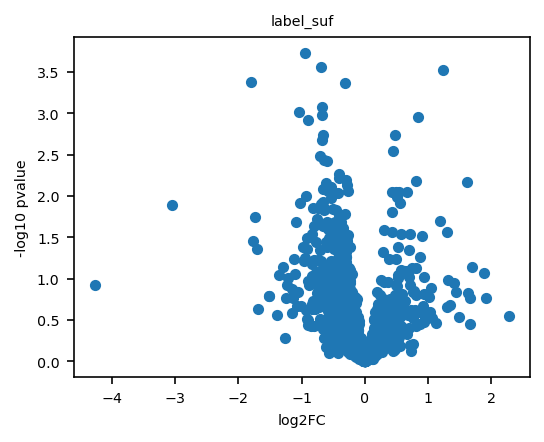

In [23]:
diff_reg.plot(x="log2FC", y="-log10 pvalue", kind="scatter", title=group)

## Interactive Volcano Plot

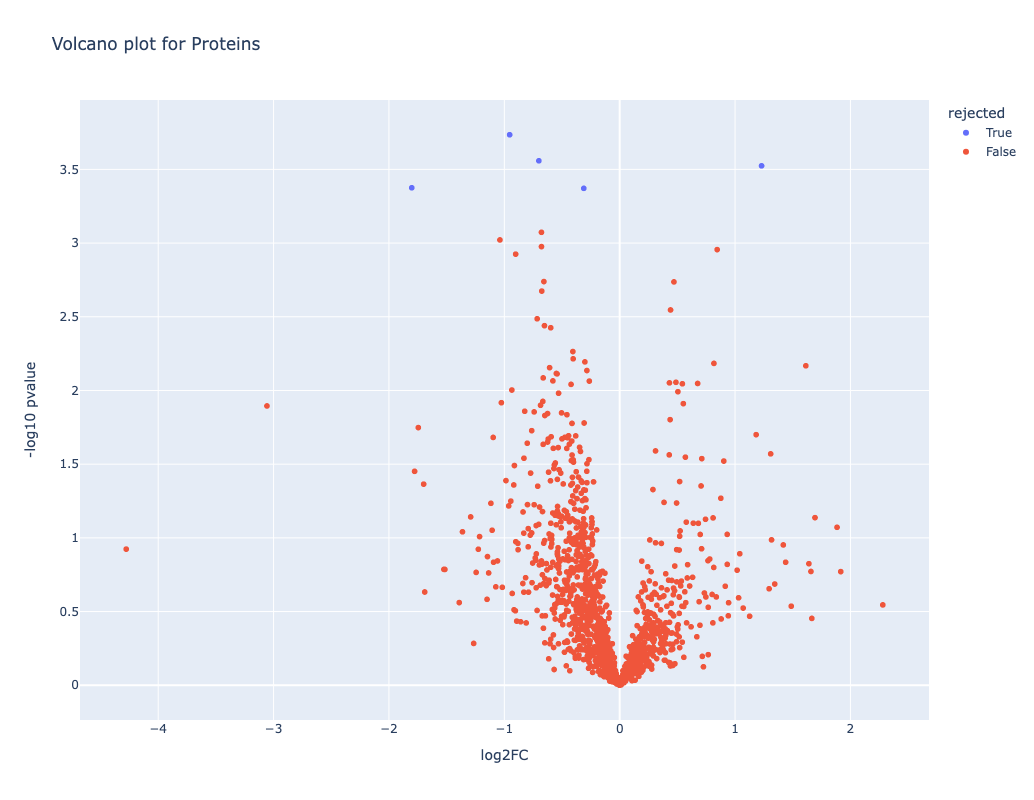

In [24]:
str_cols = diff_reg.dtypes[diff_reg.dtypes == "object"].index.tolist()
hover_data = {
    "rejected": ":.0f",
    **{
        c: ":.4f"
        for c in [
            "padj",
            "FC",
        ]
    },
    **{c: True for c in str_cols},
}
fig = px.scatter(
    diff_reg,
    x="log2FC",
    y="-log10 pvalue",
    color="rejected",
    hover_data=hover_data,
    width=1200,
    height=800,
    title=f"Volcano plot for {view_name}s",
)
fig

Save result to subsection folder

In [25]:
fig.write_json(
    out_dir_subsection / "0_volcano_plot.json",
    pretty=False,
)
diff_reg.to_csv(out_dir_subsection / "1_differential_regulation.csv")

# Enrichment Analysis

In [26]:
out_dir_subsection = out_dir / "uniprot_annotations"
out_dir_subsection.mkdir(parents=True, exist_ok=True)

Fetch the annotations from UniProt API.

In [27]:
fname_annotations = out_dir_subsection / "annotations.csv"
try:
    annotations = pd.read_csv(fname_annotations, index_col=0)
    print(f"Loaded annotations from {fname_annotations}")
except FileNotFoundError:
    print(f"Fetching annotations for {proteins.columns.size} UniProt IDs.")
    FIELDS = "go_p,go_c,go_f"
    annotations = fetch_annotations(proteins.columns, fields=FIELDS)
    annotations = process_annotations(annotations, fields=FIELDS)
    # cache the annotations
    fname_annotations.parent.mkdir(exist_ok=True, parents=True)
    annotations.to_csv(fname_annotations, index=True)

annotations

Loaded annotations from data/PXD040621/report/uniprot_annotations/annotations.csv


identifier                              source  \
6           P00350  Gene Ontology (biological process)   
7           P00350  Gene Ontology (cellular component)   
8           P00350  Gene Ontology (molecular function)   
9           P00350  Gene Ontology (molecular function)   
10          P00350  Gene Ontology (molecular function)   
...            ...                                 ...   
32,263  ADPP_ECOLI  Gene Ontology (molecular function)   
32,264  ADPP_ECOLI  Gene Ontology (molecular function)   
32,265  ADPP_ECOLI  Gene Ontology (molecular function)   
32,266  ADPP_ECOLI  Gene Ontology (biological process)   
32,267  ADPP_ECOLI  Gene Ontology (biological process)   

                                              annotation  
6             D-gluconate catabolic process [GO:0046177]  
7                                   cytosol [GO:0005829]  
8          guanosine tetraphosphate binding [GO:0097216]  
9                 identical protein binding [GO:0042802]  
10                             NADP binding [GO:0050661]  
...                                                  ...  
32,263                magnesium ion binding [GO:0000287]  
32,264    protein homodimerization activity [GO:0042803]  
32,265             pyrophosphatase activity [GO:0016462]  
32,266                     response to heat [GO:0009408]  
32,267   ribose phosphate metabolic process [GO:0019693]  

[30283 rows x 3 columns]

In [28]:
enriched = acore.enrichment_analysis.run_up_down_regulation_enrichment(
    regulation_data=diff_reg,
    annotation=annotations,
    min_detected_in_set=2,
    lfc_cutoff=1,
    pval_col="pvalue",
    correction_alpha=0.05,  # adjust the p-value to see more or less results
)
enriched

terms    identifiers  \
0             citrate metabolic process [GO:0006101]  P0A9I1,P75726   
2  ATP-independent citrate lyase complex [GO:0009...  P0A9I1,P75726   
3          acetyl-CoA metabolic process [GO:0006084]  P0A9I1,P75726   
4       citrate (pro-3S)-lyase activity [GO:0008815]  P0A9I1,P75726   
1                             cytoplasm [GO:0005737]  P0A9I1,P75726   
5                             cytoplasm [GO:0005737]  P39406,P75825   
1                   DNA damage response [GO:0006974]  P02943,P33224   
0                              membrane [GO:0016020]  P0A937,P0AAJ3   
2                             cytoplasm [GO:0005737]  P0A7P5,P33224   
3                               cytosol [GO:0005829]  P0AD49,P25665   

   foreground  background  foreground_pop  background_pop  pvalue  padj  \
0           2           0               4           1,431   0.000 0.000   
2           2           0               4           1,431   0.000 0.000   
3           2           0               4           1,431   0.000 0.000   
4           2           0               4           1,431   0.000 0.000   
1           2          27               4           1,431   0.002 0.003   
5           2         310               4           1,431   0.209 0.209   
1           2          41               8           1,431   0.022 0.088   
0           2         153               8           1,431   0.212 0.423   
2           2         310               8           1,431   0.688 0.721   
3           2         496               8           1,431   0.721 0.721   

   rejected      direction                  comparison  
0      True    upregulated  control~10 µm sulforaphane  
2      True    upregulated  control~10 µm sulforaphane  
3      True    upregulated  control~10 µm sulforaphane  
4      True    upregulated  control~10 µm sulforaphane  
1      True    upregulated  control~10 µm sulforaphane  
5     False    upregulated  control~10 µm sulforaphane  
1     False  downregulated  control~10 µm sulforaphane  
0     False  downregulated  control~10 µm sulforaphane  
2     False  downregulated  control~10 µm sulforaphane  
3     False  downregulated  control~10 µm sulforaphane

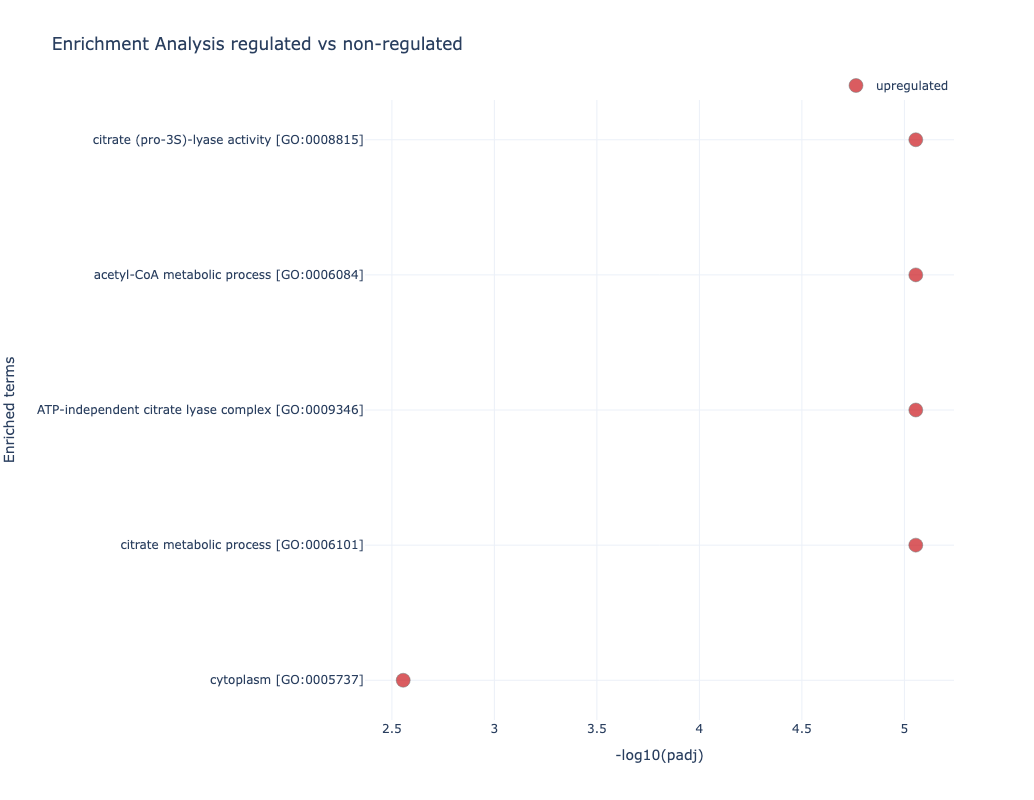

In [29]:
from vuecore.viz import get_enrichment_plots

fig = get_enrichment_plots(
    enriched,
    identifier="anything",  # ToDo: figure out what this does
    args=dict(title="Enrichment Analysis"),
)
fig = fig[0]
fig.write_json(
    out_dir_subsection / "enrichment_analysis.json",
    pretty=True,
)
fig

## Check for Maltose Uptake

In [30]:
out_dir_subsection = out_dir / "3_maltose_uptake"
out_dir_subsection.mkdir(parents=True, exist_ok=True)

apply filtering of 'differentially abundant proteins' as described in the paper
> Differentially abundant proteins were determined as those with log2 fold-change
> > 1 and < -1, and p < 0.05
This means not multiple testing correction was applied.

In [31]:
view = diff_reg.query("pvalue < 0.05 and FC > 1")  # .shape[0]
view.to_csv(
    out_dir_subsection / "1_differently_regulated_as_in_paper.csv",
    index=False,
)
view

identifier  T-statistics  pvalue  mean_group1  mean_group2  std(group1)  \
1,308     P75726         7.460   0.000       28.082       26.852        0.222   
509       P0ABK9         5.844   0.001       26.482       25.637        0.166   
1,083     P36943         5.298   0.002       28.845       28.375        0.077   
829       P11349         4.853   0.003       27.360       26.919        0.142   
1,123     P37773         4.073   0.007       27.739       26.922        0.117   
1,316     P75825         4.041   0.007       26.998       25.384        0.455   
1,139     P39285         3.816   0.009       24.661       24.173        0.045   
1,029     P31572         3.809   0.009       25.399       24.967        0.119   
1,097     P37349         3.801   0.009       25.935       25.259        0.296   
1,360     P76440         3.796   0.009       27.182       26.639        0.233   
1,379     P77252         3.691   0.010       26.517       26.012        0.099   
128       P09152         3.536   0.012       26.841       26.290        0.222   
1,318     P75829         3.332   0.016       27.617       27.180        0.137   
397       P0A9I1         3.145   0.020       28.211       27.029        0.528   
42        P04079         2.947   0.026       29.046       28.735        0.119   
1,152     P39406         2.912   0.027       27.385       26.076        0.276   
54        P05020         2.900   0.027       27.923       27.493        0.138   
60        P05637         2.872   0.028       26.621       26.051        0.262   
948       P25397         2.855   0.029       27.676       26.964        0.221   
944       P24232         2.826   0.030       27.157       26.255        0.536   
106       P08178         2.585   0.041       26.889       26.369        0.198   
1,303     P69829         2.534   0.044       26.936       26.231        0.083   
626       P0ADS9         2.493   0.047       27.321       27.032        0.101   

       std(group2)  log2FC    test         correction  padj  rejected  \
1,308        0.180   1.230  t-Test  FDR correction BH 0.122      True   
509          0.187   0.845  t-Test  FDR correction BH 0.170     False   
1,083        0.133   0.470  t-Test  FDR correction BH 0.219     False   
829          0.068   0.441  t-Test  FDR correction BH 0.291     False   
1,123        0.327   0.817  t-Test  FDR correction BH 0.383     False   
1,316        0.521   1.614  t-Test  FDR correction BH 0.383     False   
1,139        0.217   0.488  t-Test  FDR correction BH 0.383     False   
1,029        0.156   0.431  t-Test  FDR correction BH 0.383     False   
1,097        0.085   0.675  t-Test  FDR correction BH 0.383     False   
1,360        0.084   0.543  t-Test  FDR correction BH 0.383     False   
1,379        0.215   0.505  t-Test  FDR correction BH 0.404     False   
128          0.153   0.552  t-Test  FDR correction BH 0.434     False   
1,318        0.181   0.437  t-Test  FDR correction BH 0.460     False   
397          0.381   1.183  t-Test  FDR correction BH 0.493     False   
42           0.138   0.311  t-Test  FDR correction BH 0.508     False   
1,152        0.728   1.309  t-Test  FDR correction BH 0.516     False   
54           0.216   0.430  t-Test  FDR correction BH 0.516     False   
60           0.223   0.570  t-Test  FDR correction BH 0.519     False   
948          0.371   0.712  t-Test  FDR correction BH 0.519     False   
944          0.137   0.903  t-Test  FDR correction BH 0.519     False   
106          0.286   0.519  t-Test  FDR correction BH 0.565     False   
1,303        0.475   0.705  t-Test  FDR correction BH 0.565     False   
626          0.173   0.288  t-Test  FDR correction BH 0.580     False   

        group1              group2    FC  -log10 pvalue           Method  
1,308  control  10 µm sulforaphane 2.345          3.524  Unpaired t-test  
509    control  10 µm sulforaphane 1.796          2.956  Unpaired t-test  
1,083  control  10 µm sulforaphane 1.386          2.737  Unpaired t-test  
829    c

Let's find the proteins highlighted in the volcano plot in Figure 3.

In [32]:
highlighted_genes = ["LamB", "MalE", "Malk", "CitF", "CitT", "CitE", "Frd"]
highlighted_genes = "|".join([p.upper() for p in highlighted_genes])
highlighted_genes = proteins_meta.query(
    f"`GeneName`.str.contains('{highlighted_genes}')"
)
highlighted_genes

Source ProteinName GeneName
identifier                                      
sp|P00363|FRDA_ECOLI     sp      P00363     FRDA
sp|P02943|LAMB_ECOLI     sp      P02943     LAMB
sp|P0A8Q0|FRDC_ECOLI     sp      P0A8Q0     FRDC
sp|P0A8Q3|FRDD_ECOLI     sp      P0A8Q3     FRDD
sp|P0A9I1|CITE_ECOLI     sp      P0A9I1     CITE
sp|P0AC47|FRDB_ECOLI     sp      P0AC47     FRDB
sp|P0AE74|CITT_ECOLI     sp      P0AE74     CITT
sp|P0AEX9|MALE_ECOLI     sp      P0AEX9     MALE
sp|P68187|MALK_ECOLI     sp      P68187     MALK

In [33]:
highlighted_proteins = "|".join([p.upper() for p in highlighted_genes["ProteinName"]])
view = diff_reg.query(f"`identifier`.str.contains('{highlighted_proteins}')")
view.to_csv(
    out_dir_subsection / "2_highlighted_proteins_in_figure3.csv",
    index=False,
)
view

identifier  T-statistics  pvalue  mean_group1  mean_group2  std(group1)  \
36      P02943        -7.006   0.000       26.117       27.920        0.428   
700     P0AEX9        -4.137   0.006       27.007       27.411        0.092   
397     P0A9I1         3.145   0.020       28.211       27.029        0.528   
655     P0AE74         1.983   0.095       26.452       25.520        0.802   
337     P0A8Q0         1.609   0.159       29.707       28.892        0.762   
1       P00363         0.629   0.552       30.033       29.937        0.128   
536     P0AC47         0.257   0.806       30.912       30.849        0.206   

     std(group2)  log2FC    test         correction  padj  rejected   group1  \
36         0.124  -1.802  t-Test  FDR correction BH 0.122      True  control   
700        0.142  -0.403  t-Test  FDR correction BH 0.383     False  control   
397        0.381   1.183  t-Test  FDR correction BH 0.493     False  control   
655        0.141   0.932  t-Test  FDR correction BH 0.662     False  control   
337        0.436   0.815  t-Test  FDR correction BH 0.705     False  control   
1          0.232   0.096  t-Test  FDR correction BH 0.925     False  control   
536        0.372   0.063  t-Test  FDR correction BH 0.965     False  control   

                 group2    FC  -log10 pvalue           Method  
36   10 µm sulforaphane 0.287          3.375  Unpaired t-test  
700  10 µm sulforaphane 0.756          2.215  Unpaired t-test  
397  10 µm sulforaphane 2.270          1.700  Unpaired t-test  
655  10 µm sulforaphane 1.908          1.024  Unpaired t-test  
337  10 µm sulforaphane 1.760          0.799  Unpaired t-test  
1    10 µm sulforaphane 1.069          0.258  Unpaired t-test  
536  10 µm sulforaphane 1.045          0.094  Unpaired t-test

How to explain the differences?